In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
# Load the data
df = pd.read_csv('TABASCO_CAMPECHE_fishing_reports.csv', low_memory=False)

# Convert the date to datetime format and extract the year and month
df['FECHA AVISO'] = pd.to_datetime(df['FECHA AVISO'], format='%d/%m/%Y')
df['YEAR'] = df['FECHA AVISO'].dt.year
df['MONTH'] = df['FECHA AVISO'].dt.month

# Exclude the year 2016 and the species 'OSTION'
df = df[df['YEAR'] != 2016]
df = df[df['NOMBRE PRINCIPAL'] != 'OSTION']

# Correct the name of the office
df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')

In [16]:
# Create a new column for the value of the catch
df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

# 1. Identify the top 10 NOMBRE PRINCIPAL by their catch volume in PESO DESEMBARCADO_KILOGRAMOS
by_volume = df.groupby('NOMBRE PRINCIPAL')['PESO DESEMBARCADO_KILOGRAMOS'].sum()

# 2. Identify the top 10 NOMBRE PRINCIPAL by the value of the catch
by_value = df.groupby('NOMBRE PRINCIPAL')['Value (MXN)'].sum()

# 3. Identify the frequency with which each NOMBRE PRINCIPAL of the top 10 by volume is reported
by_frequency = df[df['NOMBRE PRINCIPAL'].isin(by_volume.index)]['NOMBRE PRINCIPAL'].value_counts()

# Calculate the percentage of catch, value, and frequency
total_volume = df['PESO DESEMBARCADO_KILOGRAMOS'].sum()
total_value = df['Value (MXN)'].sum()
total_reports = len(df)

percent_volume = by_volume / total_volume * 100
percent_value = by_value / total_value * 100
percent_frequency = by_frequency / total_reports * 100

# Create a DataFrame for the percentages
iir_df = pd.DataFrame({
    'NOMBRE PRINCIPAL': by_volume.index,
    '% Capture': percent_volume.values,
    '% Value': percent_value.reindex(by_volume.index).values,
    '% Frequency': percent_frequency.reindex(by_volume.index).values
})

# Calculate the Relative Importance Index (IIR)
iir_df['IIR'] = (iir_df['% Capture'] + iir_df['% Value'] + iir_df['% Frequency']) / 3

# Sort by IIR in descending order
iir_df = iir_df.sort_values(by='IIR', ascending=False)

# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]
# Display the final table
iir_df[:10]



,NOMBRE PRINCIPAL,% Capture,% Value,% Frequency,IIR
36,PULPO,16.656549,31.298564,10.600304,19.518472
38,ROBALO,6.305386,15.088845,11.099888,10.831373
22,JUREL,14.302105,4.470483,11.350484,10.041024
31,OTRAS,6.940229,7.211573,10.489643,8.213815
4,BANDERA,7.441790,3.176903,4.126469,4.915054
30,MOJARRA,3.913921,4.297987,5.171959,4.461289
41,RUBIO,3.312640,1.751500,7.447750,4.170630
21,JAIBA,6.657044,3.111233,2.338842,4.035706
20,GUACHINANGO,2.423850,5.570791,2.925281,3.639974
18,CORVINA,2.416654,1.948383,5.505551,3.290196


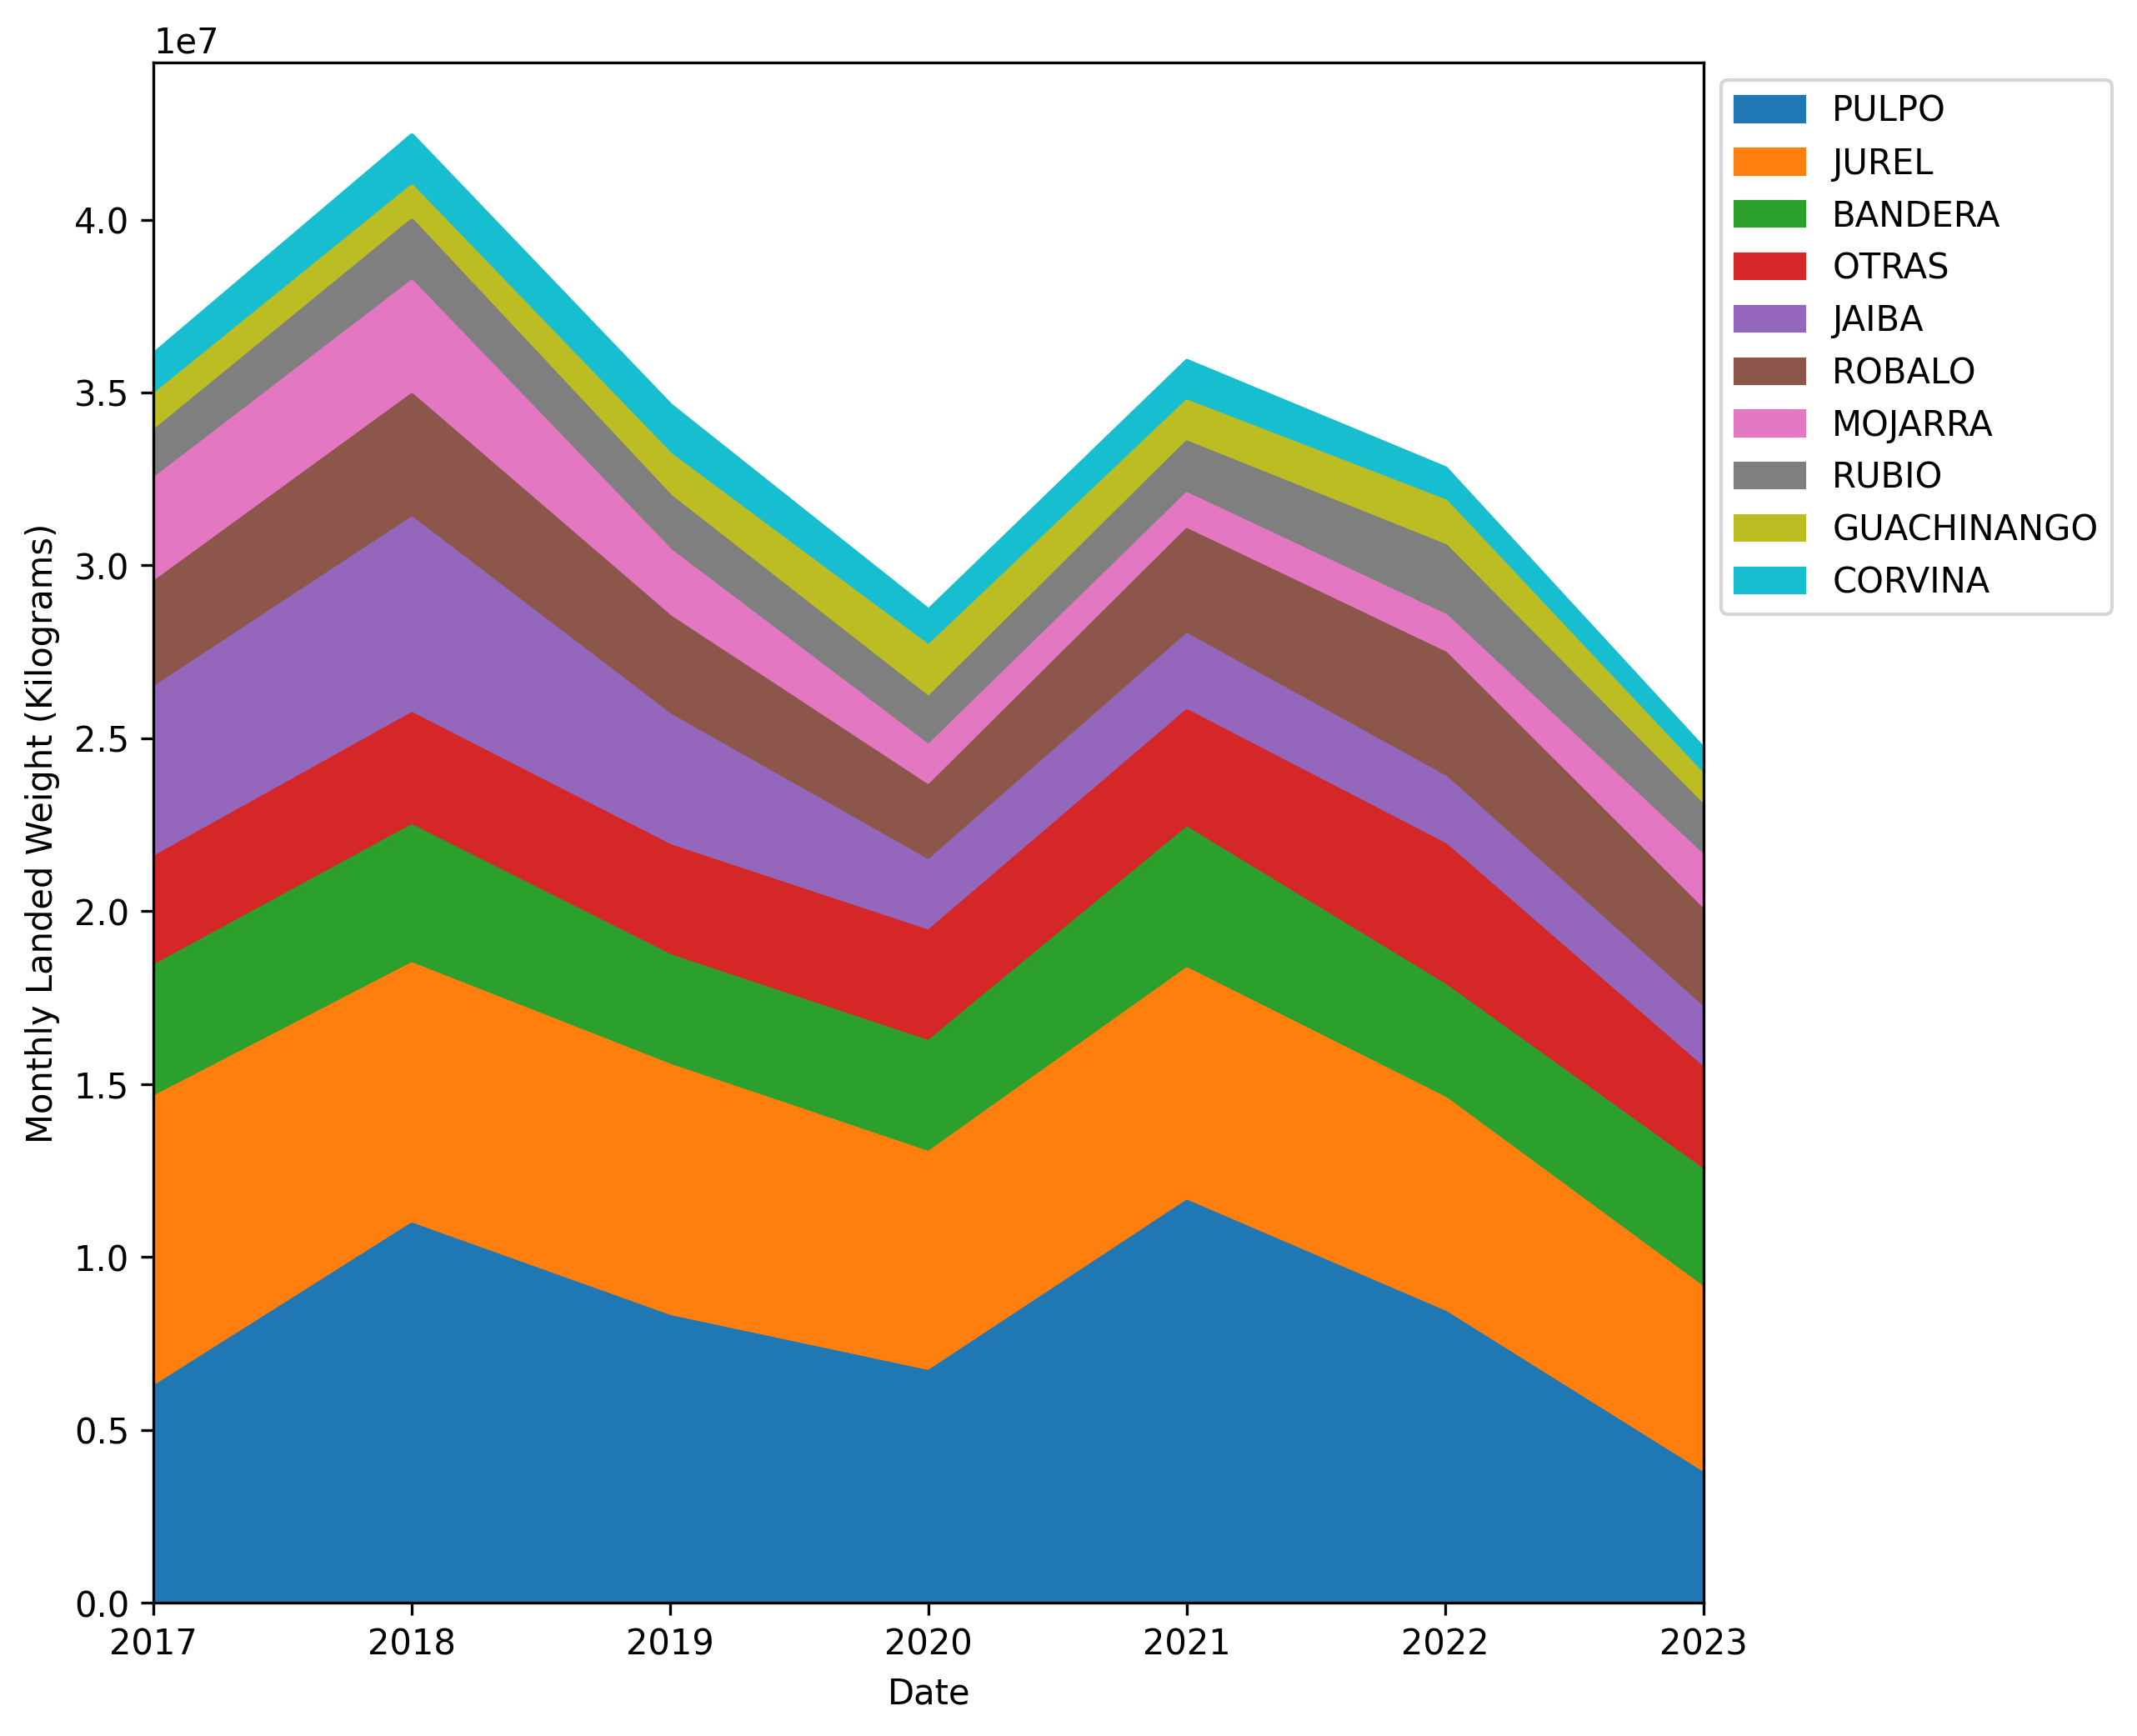

In [18]:


# Group by year, month, and species to get the monthly data
monthly_df = top_10_species_df.groupby([pd.Grouper(key='FECHA AVISO', freq='YE'), 'NOMBRE PRINCIPAL'])['PESO DESEMBARCADO_KILOGRAMOS'].sum().unstack().fillna(0)

# Sort the columns according to the total catch
ordered_columns = monthly_df.sum().sort_values(ascending=False).index
monthly_df = monthly_df[ordered_columns]

# Plot the monthly time series with stacked areas
plt.figure(figsize=(8, 8),dpi=300)
monthly_df.plot.area(stacked=True, ax=plt.gca())
#plt.title('Monthly Time Series of the Top 10 Species by Landed Weight')
plt.xlabel('Date')
plt.ylabel('Monthly Landed Weight (Kilograms)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

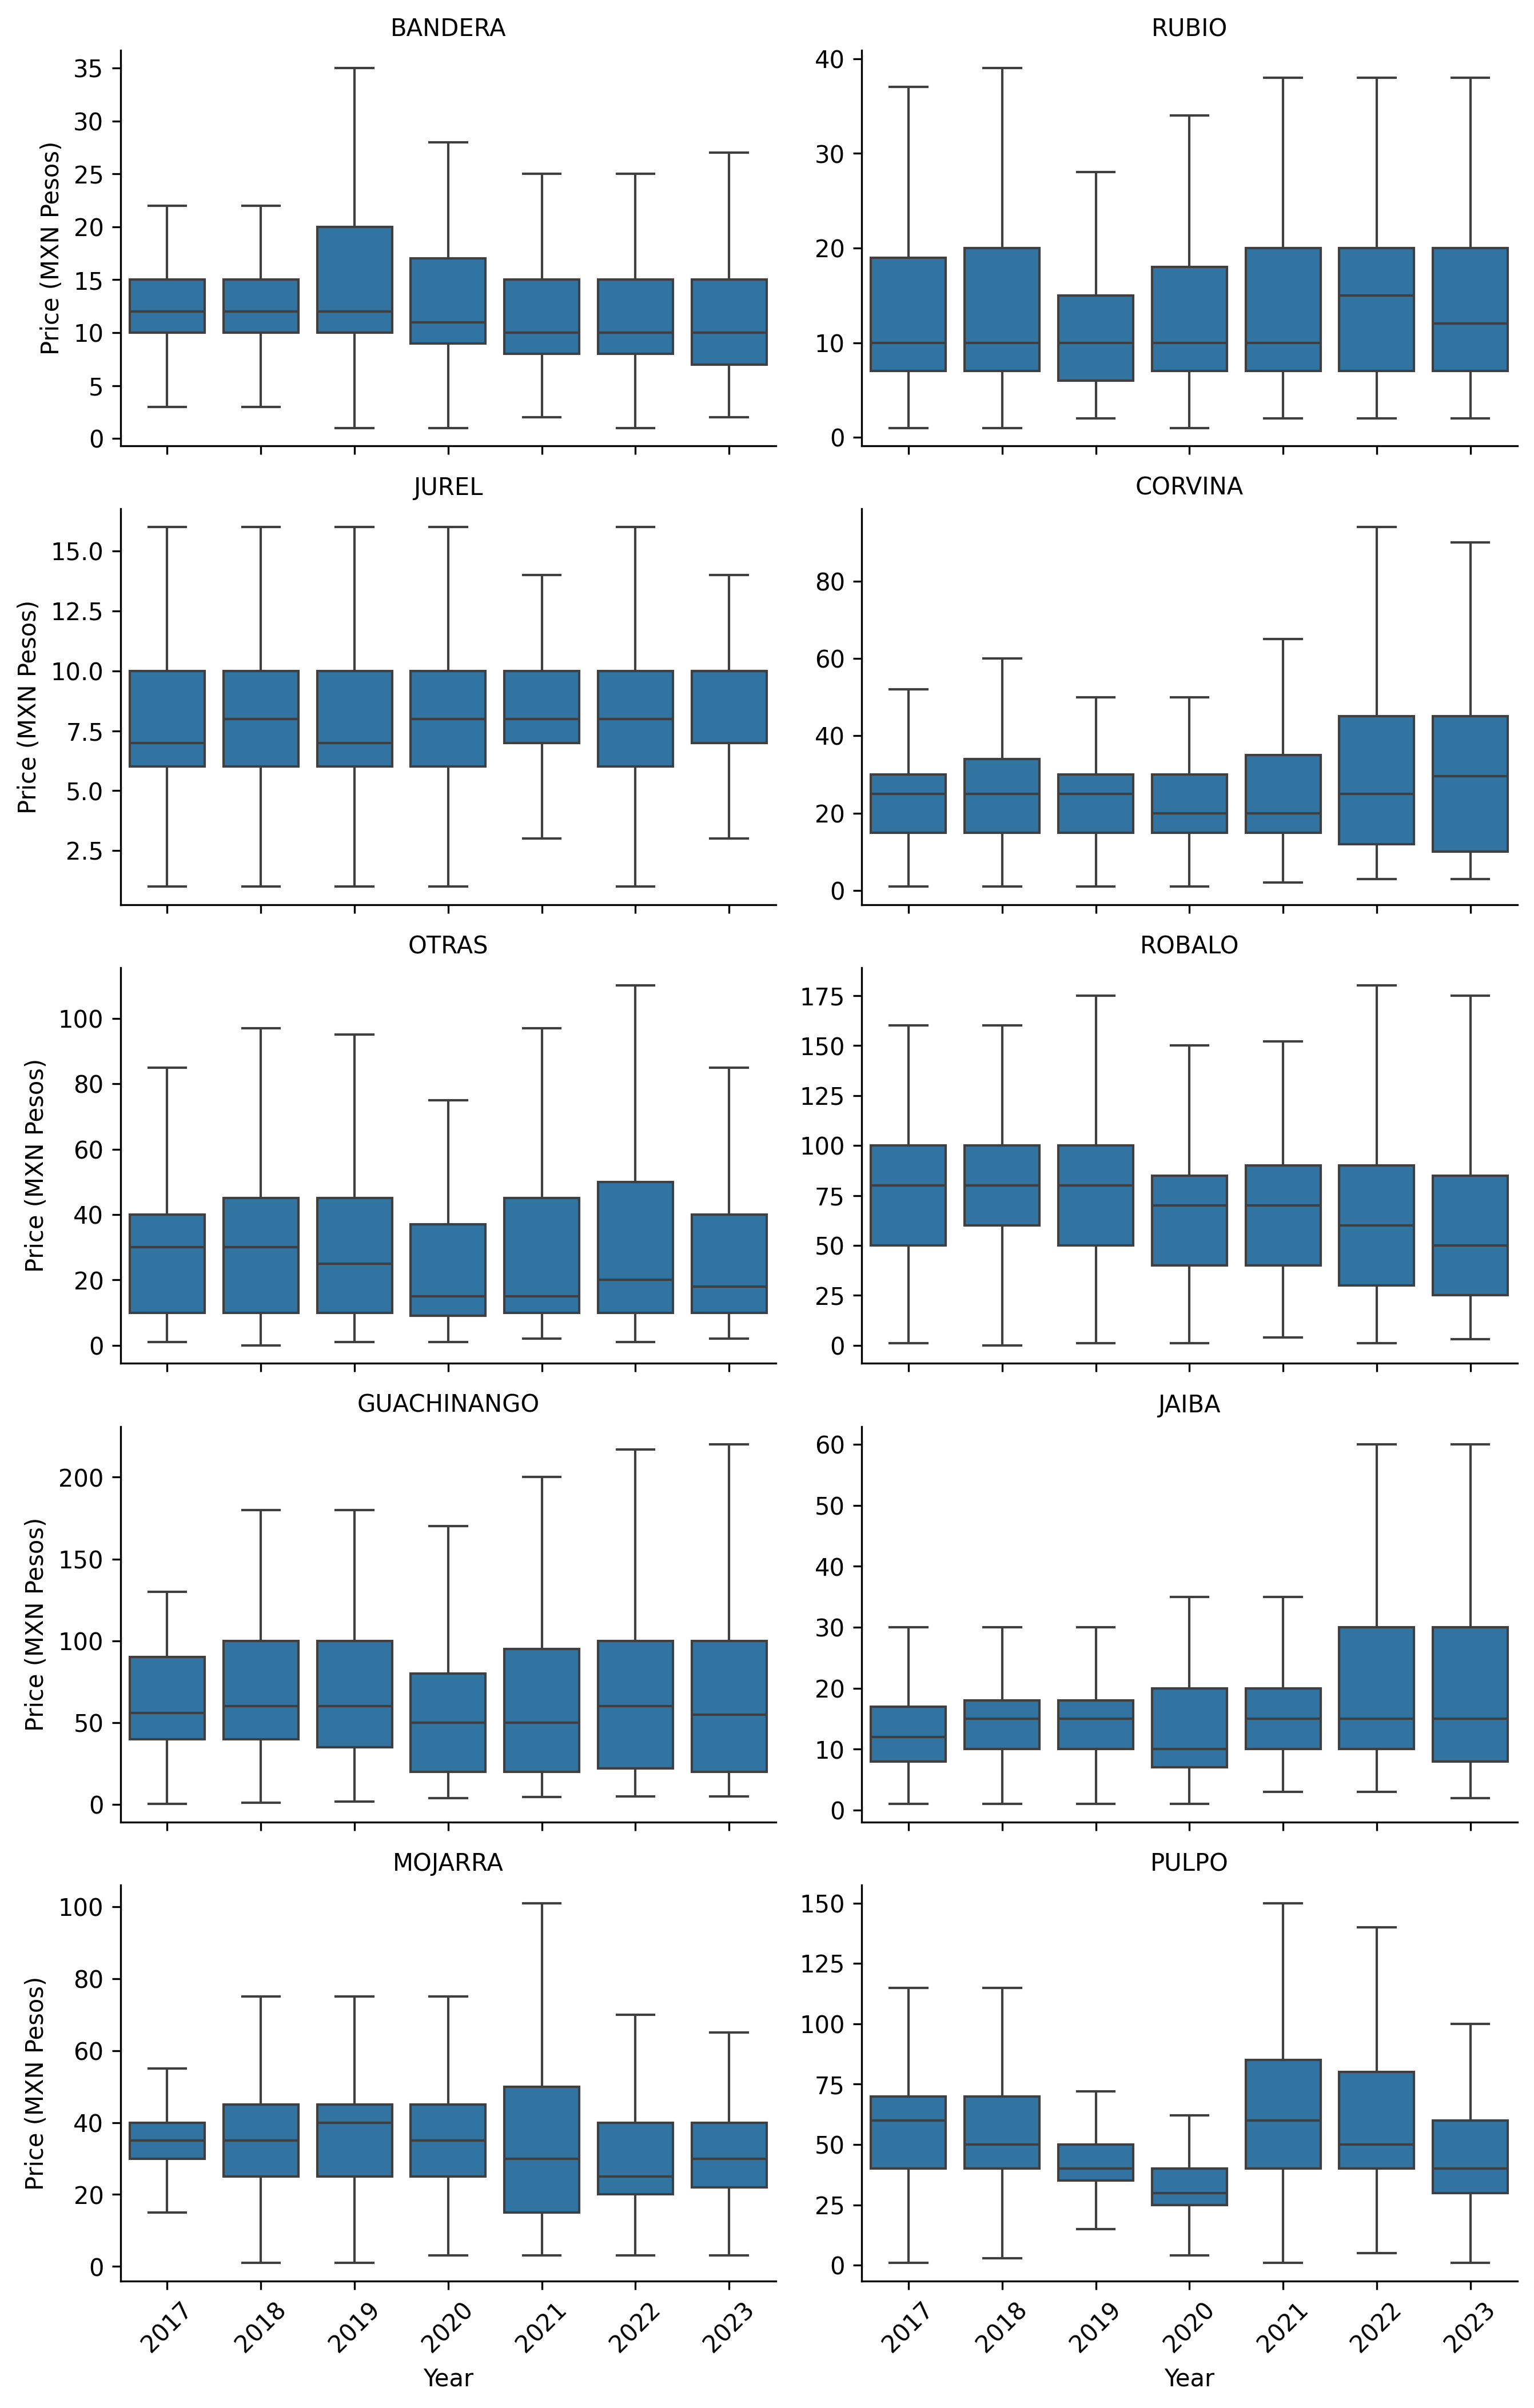

In [19]:

import seaborn as sns
# Filter data for the top 10 species by IIR
top_10_species_df = df[df['NOMBRE PRINCIPAL'].isin(iir_df['NOMBRE PRINCIPAL'].head(10))]

# Create a multi-panel boxplot for annual prices
g = sns.FacetGrid(top_10_species_df, col='NOMBRE PRINCIPAL', col_wrap=2, height=3, aspect=1.5, sharey=False)
g.map_dataframe(sns.boxplot, x='YEAR', y='PRECIO_PESOS', showfliers=False)
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Price (MXN Pesos)')
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
g.fig.tight_layout(w_pad=1)  # Adjust layout

# Add a main title
plt.subplots_adjust(top=0.92)
#g.fig.suptitle('Annual Price Distribution for Top 10 Species by IIR')
plt.gcf().set_dpi(300)
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_18328\3304430722.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=scatter.cmap(cluster / (species_summary['Cluster'].max())), label=f'Cluster {cluster}')


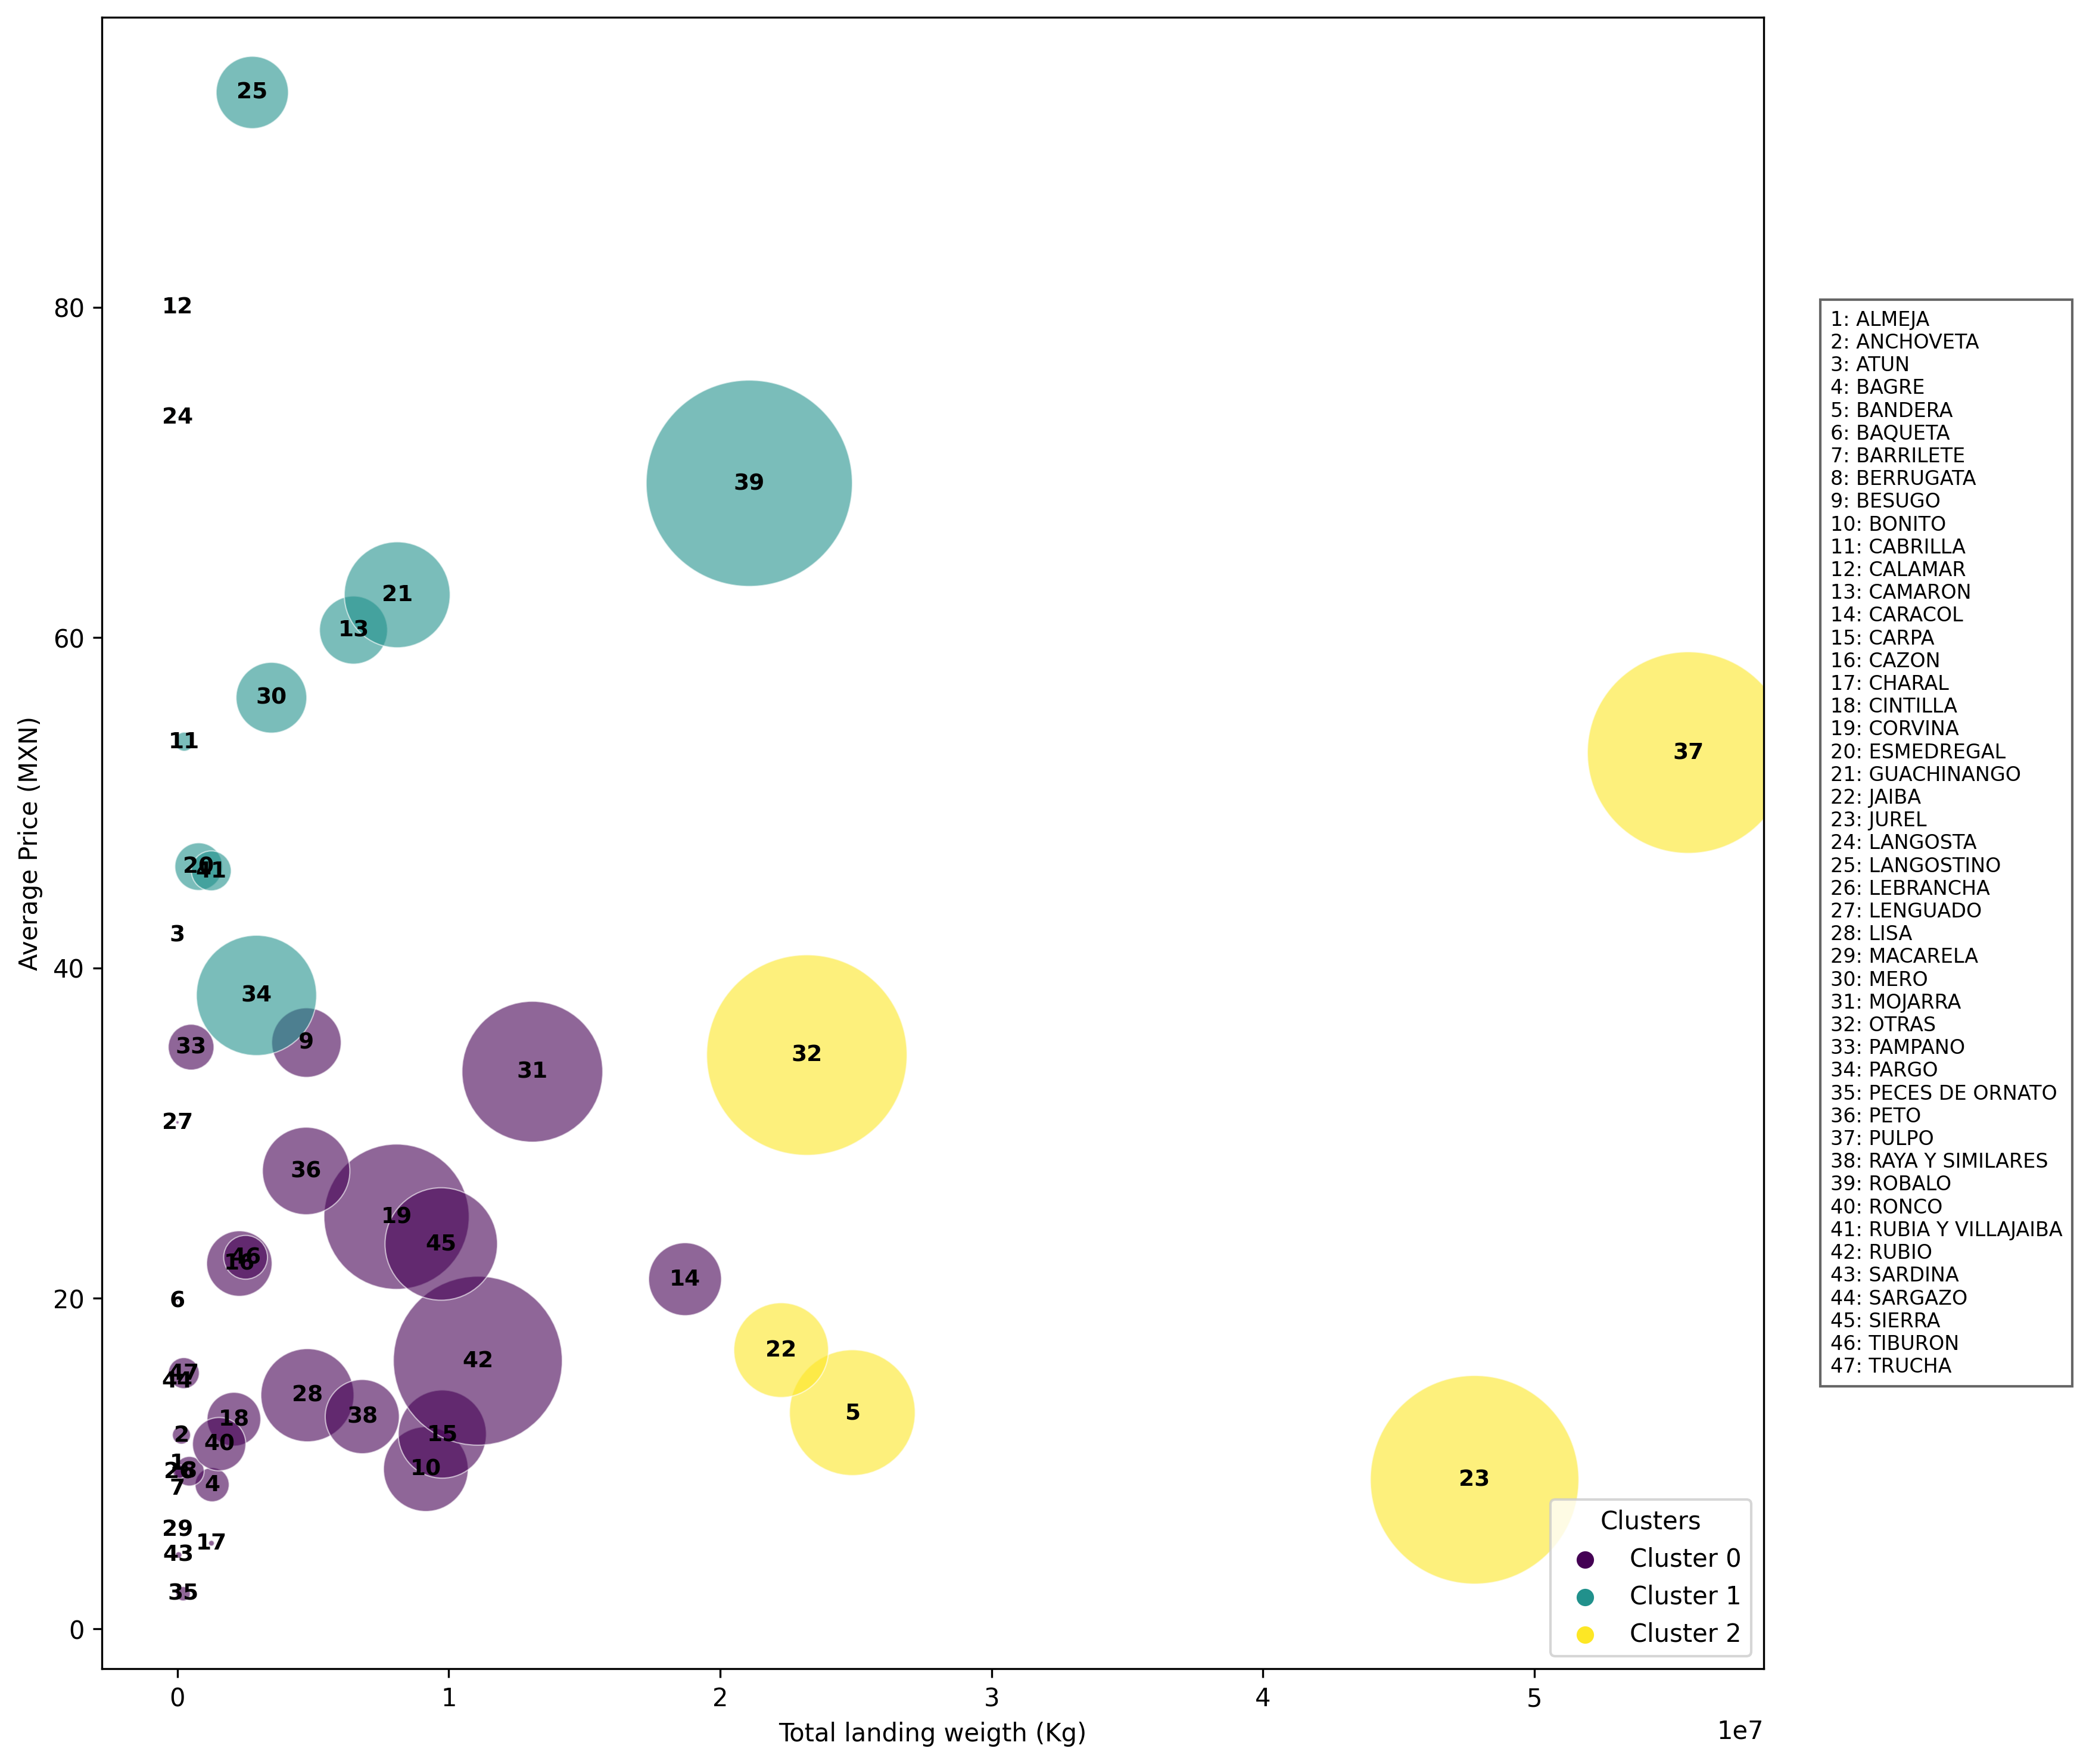

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Agrupar los datos por "Nombre Principal" para calcular los totales y el precio promedio
species_summary = df.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean',
    'NOMBRE PRINCIPAL': 'count'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG)',
    'PRECIO_PESOS': 'Precio Promedio (MXN)',
    'NOMBRE PRINCIPAL': 'Frecuencia de Registro'
}).reset_index()

# Asignar un código numérico a cada especie
species_codes = {species: i for i, species in enumerate(species_summary['NOMBRE PRINCIPAL'], 1)}
species_summary['Código'] = species_summary['NOMBRE PRINCIPAL'].map(species_codes)

# Realizar el análisis de clustering
X = species_summary[['Total Peso Desembarcado (KG)', 'Precio Promedio (MXN)']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
species_summary['Cluster'] = kmeans.fit_predict(X_scaled)

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 12),dpi=300)
scatter = plt.scatter(
    species_summary['Total Peso Desembarcado (KG)'],
    species_summary['Precio Promedio (MXN)'],
    c=species_summary['Cluster'],
    cmap='viridis',
    s=species_summary['Frecuencia de Registro'] /10,  # Ajustar el tamaño de los puntos según la frecuencia
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

# Añadir los códigos numéricos como etiquetas
for i, row in species_summary.iterrows():
    plt.text(row['Total Peso Desembarcado (KG)'], row['Precio Promedio (MXN)'], str(row['Código']),
             fontsize=9, ha='center', va='center', color='black', fontweight='bold')

# Añadir leyenda de los clusters
for cluster in species_summary['Cluster'].unique():
    plt.scatter([], [], c=scatter.cmap(cluster / (species_summary['Cluster'].max())), label=f'Cluster {cluster}')
plt.legend(title="Clusters", loc="lower right")

# Añadir la lista de especies con sus códigos como leyenda
legend_text = "\n".join([f"{code}: {species}" for species, code in species_codes.items()])
plt.gca().text(1.04, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.6))

# Añadir etiquetas y título
plt.xlabel('Total landing weigth (Kg)')
plt.ylabel('Average Price (MXN)')
#plt.title('Dispersión de Captura vs Precio con Tamaño de Frecuencia e Identificación de Clusters')
plt.show()

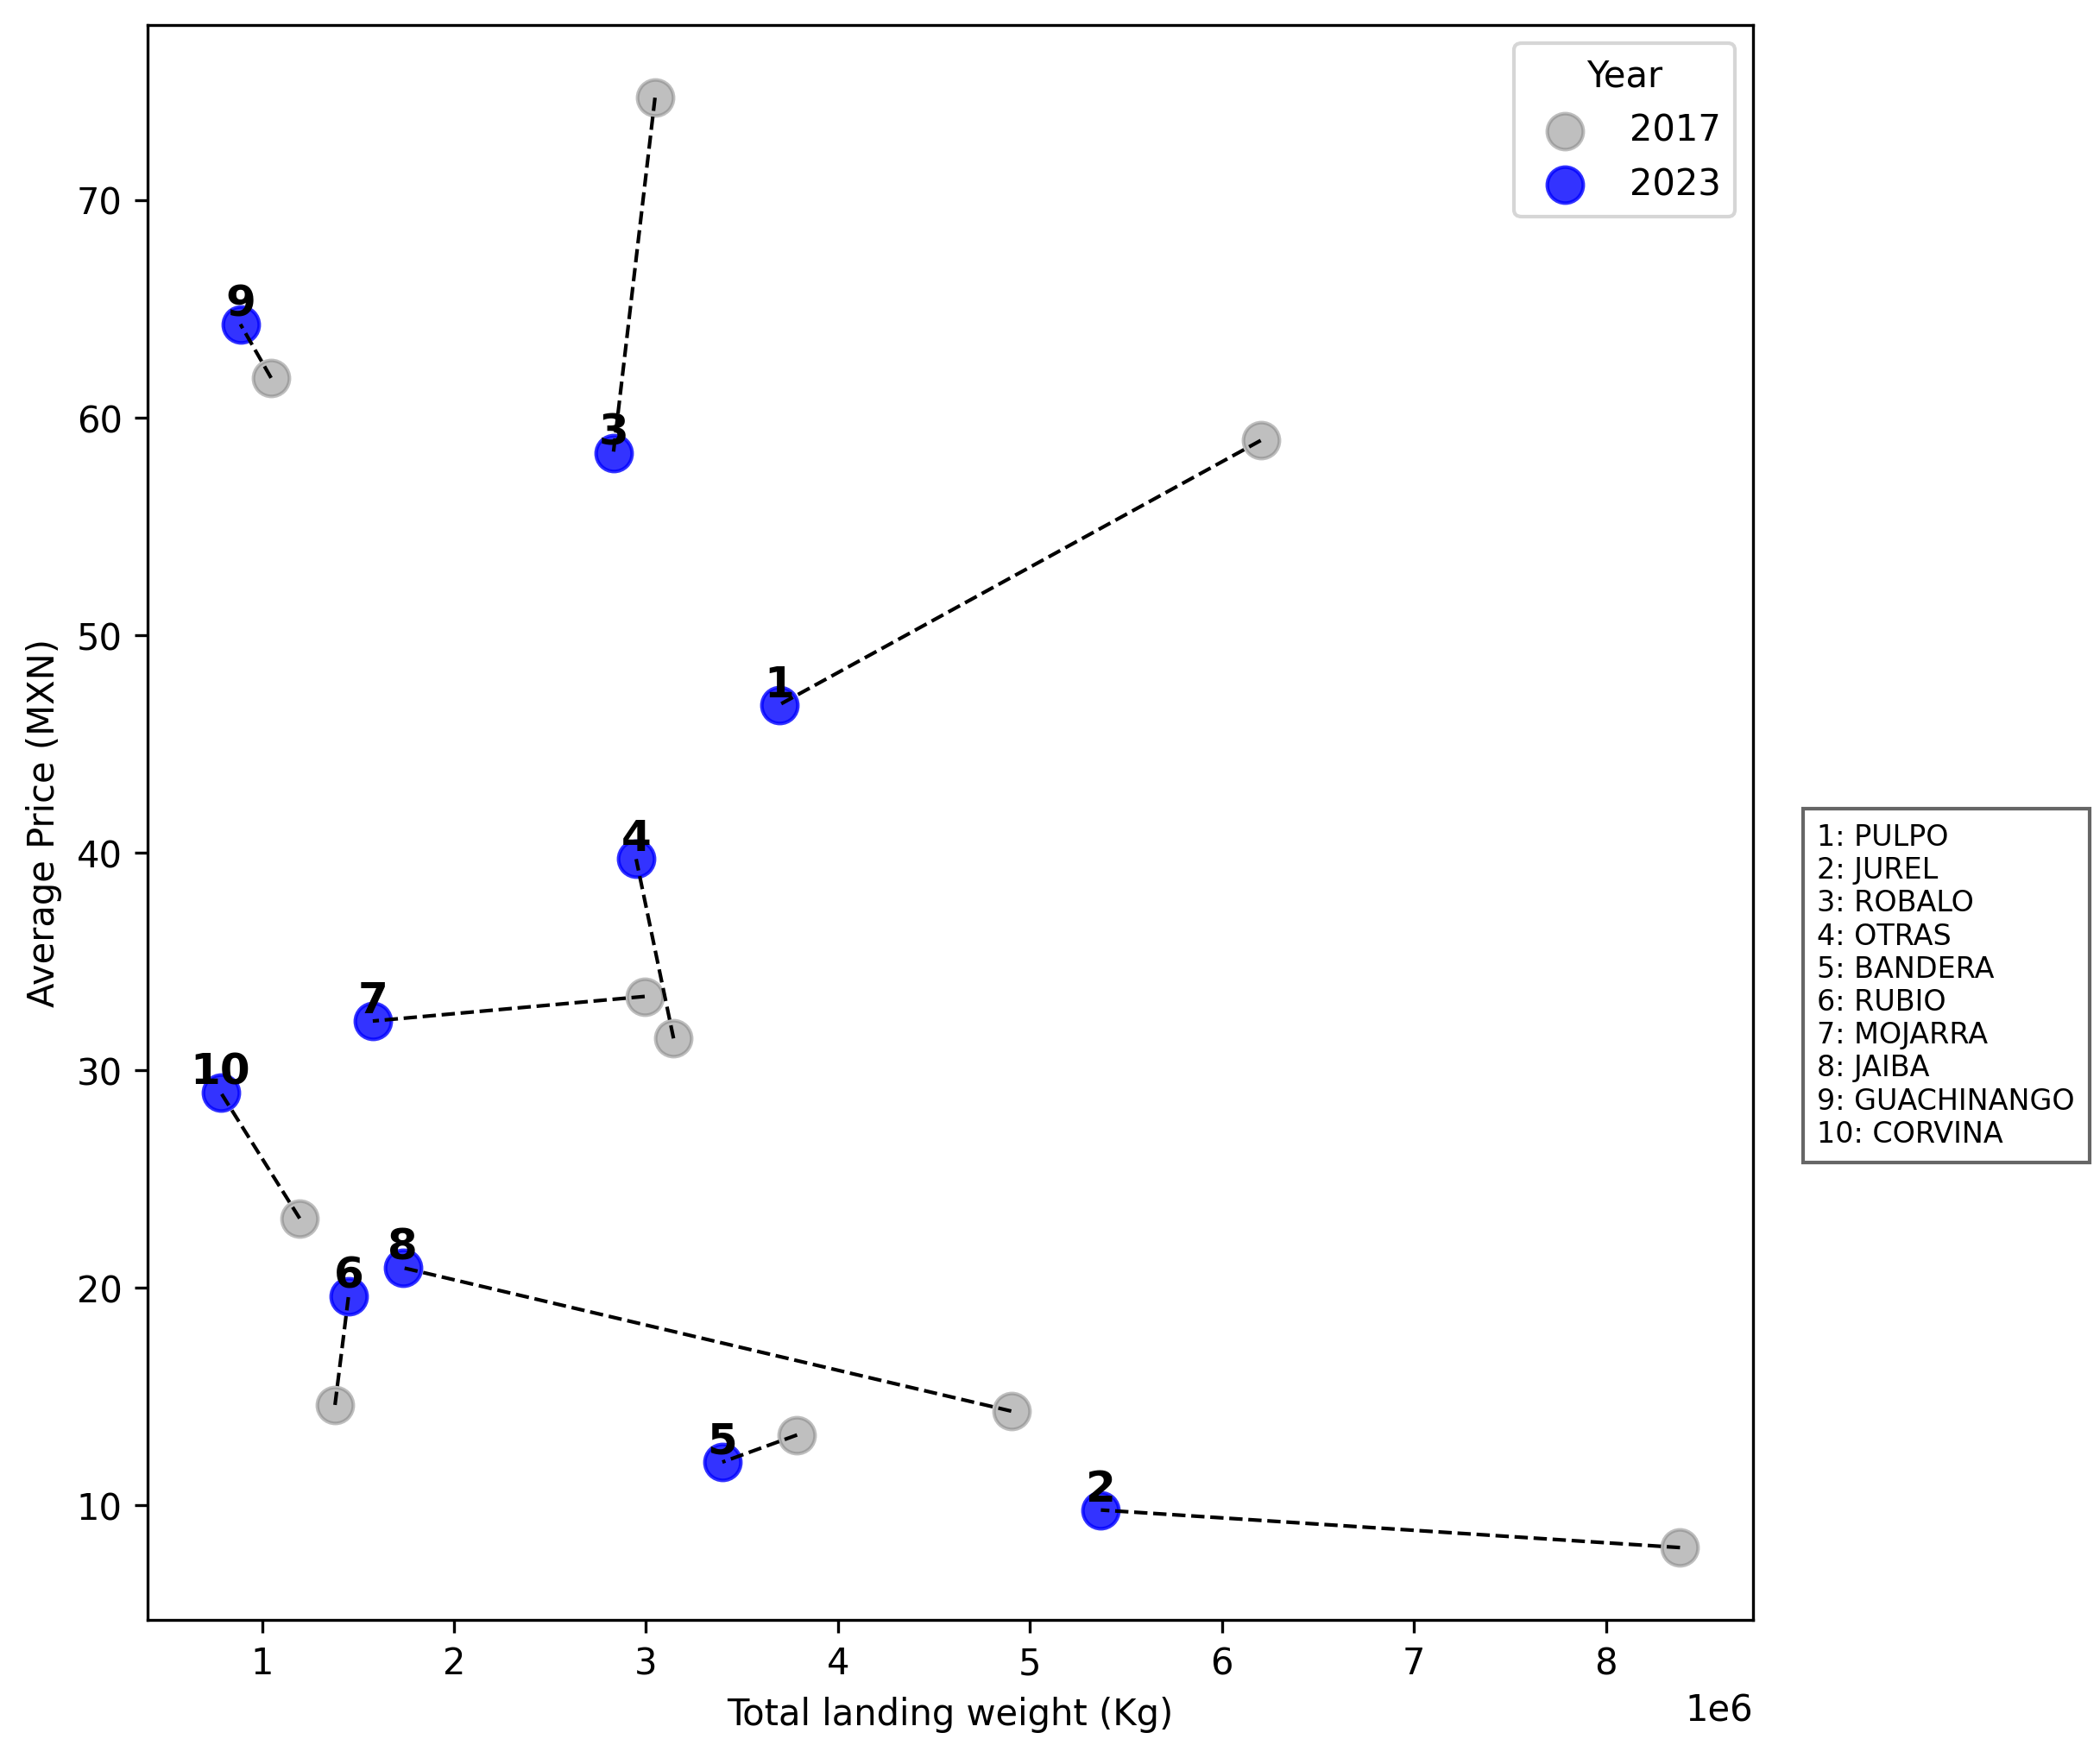

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('TABASCO_CAMPECHE_fishing_reports.csv', low_memory=False)

# Convert the date to datetime format and extract the year and month
df['FECHA AVISO'] = pd.to_datetime(df['FECHA AVISO'], format='%d/%m/%Y')
df['YEAR'] = df['FECHA AVISO'].dt.year
df['MONTH'] = df['FECHA AVISO'].dt.month

# Exclude the year 2016 and the species 'OSTION'
df = df[df['YEAR'] != 2016]
df = df[df['NOMBRE PRINCIPAL'] != 'OSTION']

# Correct the name of the office
df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')

# Create a new column for the value of the catch
df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

# Calculate IIR for all species
species_summary = df.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean',
    'NOMBRE PRINCIPAL': 'count'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG)',
    'PRECIO_PESOS': 'Precio Promedio (MXN)',
    'NOMBRE PRINCIPAL': 'Frecuencia de Registro'
}).reset_index()

# Calculate IIR
percent_volume = (species_summary['Total Peso Desembarcado (KG)'] / species_summary['Total Peso Desembarcado (KG)'].sum()) * 100
percent_value = (species_summary['Precio Promedio (MXN)'] / species_summary['Precio Promedio (MXN)'].sum()) * 100
percent_frequency = (species_summary['Frecuencia de Registro'] / species_summary['Frecuencia de Registro'].sum()) * 100
species_summary['IIR'] = (percent_volume + percent_value + percent_frequency) / 3

# Filter top 10 species by IIR and assign labels 1 to 10
top_species_summary = species_summary.nlargest(10, 'IIR').reset_index(drop=True)
top_species_summary['Label'] = range(1, 11)

# Extract data for the years 2017 and 2023
data_2017 = df[(df['YEAR'] == 2017) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]
data_2023 = df[(df['YEAR'] == 2023) & (df['NOMBRE PRINCIPAL'].isin(top_species_summary['NOMBRE PRINCIPAL']))]

# Calculate summary statistics for 2017 and 2023
summary_2017 = data_2017.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2017',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2017'
}).reset_index()

summary_2023 = data_2023.groupby('NOMBRE PRINCIPAL').agg({
    'PESO DESEMBARCADO_KILOGRAMOS': 'sum',
    'PRECIO_PESOS': 'mean'
}).rename(columns={
    'PESO DESEMBARCADO_KILOGRAMOS': 'Total Peso Desembarcado (KG) 2023',
    'PRECIO_PESOS': 'Precio Promedio (MXN) 2023'
}).reset_index()

# Merge 2017 and 2023 summaries
merged_summary = pd.merge(summary_2017, summary_2023, on='NOMBRE PRINCIPAL', suffixes=('_2017', '_2023'))
merged_summary = pd.merge(merged_summary, top_species_summary[['NOMBRE PRINCIPAL', 'Label']], on='NOMBRE PRINCIPAL')

# Plotting
plt.figure(figsize=(8, 8), dpi=300)

# Plot data points and lines for top 10 species
for i, row in merged_summary.iterrows():
    plt.scatter(row['Total Peso Desembarcado (KG) 2017'], row['Precio Promedio (MXN) 2017'], color='gray', alpha=0.5, marker='o', s=100, label='2017' if i == 0 else "")
    plt.scatter(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], color='blue', alpha=0.8, marker='o', s=100, label='2023' if i == 0 else "")
    plt.plot([row['Total Peso Desembarcado (KG) 2017'], row['Total Peso Desembarcado (KG) 2023']], 
             [row['Precio Promedio (MXN) 2017'], row['Precio Promedio (MXN) 2023']], 
             'k--', lw=1)
    plt.text(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], str(row['Label']),
             fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')

# Add legend for years
plt.legend(title="Year", loc="upper right")

# Add species list with codes as a legend
legend_text = "\n".join([f"{row['Label']}: {row['NOMBRE PRINCIPAL']}" for i, row in top_species_summary.iterrows()])
plt.gca().text(1.04, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Add labels and title
plt.xlabel('Total landing weight (Kg)')
plt.ylabel('Average Price (MXN)')
#plt.title('Scatter Plot of Landing Weight vs. Average Price with Frequency Size and Species Identification')
plt.show()
